# Training Teacher


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from pathlib import Path

# === Parameter ===
FEATURE_DIR = "data/en/features_clean"
LABEL_DIR = "data/en/labels_clean"
segment_len = 100
input_dim = 39
BATCH_SIZE = 32
EPOCHS = 30

# === Schritt 1: Alle Phoneme erkennen ===
all_labels = []
for file in os.listdir(LABEL_DIR):
    with open(os.path.join(LABEL_DIR, file)) as f:
        labels = [line.strip() for line in f.readlines()]
        all_labels.extend(labels)

distinct_phonemes = sorted(set(all_labels))
print("📌 Gefundene Phoneme:", distinct_phonemes)

label_encoder = LabelEncoder()
label_encoder.fit(distinct_phonemes)

# === Mittelwert und Std laden ===
mean = np.load("feature_mean.npy")
std = np.load("feature_std.npy")

# === Hilfsfunktionen ===
def split_sequence(X, y, segment_len):
    segments_X, segments_y = [], []
    max_start = (len(X) // segment_len) * segment_len
    for start in range(0, max_start, segment_len):
        segments_X.append(X[start:start + segment_len])
        segments_y.append(y[start:start + segment_len])
    return segments_X, segments_y

# === Daten laden ===
X_all, y_all = [], []
for file in os.listdir(FEATURE_DIR):
    if not file.endswith(".npy"):
        continue
    base = os.path.splitext(file)[0]
    features = np.load(os.path.join(FEATURE_DIR, file))
    features = (features - mean) / std
    with open(os.path.join(LABEL_DIR, f"{base}.txt")) as f:
        labels = [line.strip() for line in f.readlines()]
    if len(features) != len(labels):
        continue
    labels_encoded = label_encoder.transform(labels)
    X_seg, y_seg = split_sequence(features, labels_encoded, segment_len)
    X_all.extend(X_seg)
    y_all.extend(y_seg)

X_all = np.array(X_all)
y_all = np.array(y_all)

print(f"✅ Geladen: {X_all.shape[0]} Sequenzen á {segment_len} Frames")

# === Daten mischen ===
indices = np.arange(len(X_all))
np.random.shuffle(indices)
X_all = X_all[indices]
y_all = y_all[indices]

# === Class Weights berechnen ===
flat_labels = y_all.flatten()
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(distinct_phonemes)),
    y=flat_labels
)
class_weights = dict(enumerate(class_weights_array))
print("⚖️ Class Weights:", class_weights)

In [5]:
# === Modell definieren ===
inputs = Input(shape=(segment_len, input_dim), name="input_layer")

x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.GRU(256, return_sequences=True)(x)
x = layers.GRU(256, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)

x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
outputs = layers.TimeDistributed(
    layers.Dense(len(distinct_phonemes), activation='softmax')
)(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# === Training ===
history = model.fit(
    X_all, y_all,
    validation_split=0.1,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)],
)

# === Modell speichern ===
model.save("teacher_phoneme_model.h5")
model.save("teacher_phoneme_model_tf", save_format="tf")

# === Evaluation (Confusion Matrix) ===
N = int(0.1 * len(X_all))
X_val = X_all[-N:]
y_val = y_all[-N:]
y_pred = model.predict(X_val).argmax(-1)

y_true_flat = y_val.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(len(distinct_phonemes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90)
plt.tight_layout()
plt.title("Confusion Matrix (Validation)")
plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 39)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 100, 128)            │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 100, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 100, 256)            │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 100, 256)            │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 100, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 100, 64)             │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 100, 40)             │           2,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 810,344 (3.09 MB)

 Trainable params: 809,832 (3.09 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/30
3550/3550 ━━━━━━━━━━━━━━━━━━━━ 508s 141ms/step - accuracy: 0.5268 - loss: 1.8343 - val_accuracy: 0.6289 - val_loss: 1.2771 - learning_rate: 1.0000e-04
Epoch 2/30
3550/3550 ━━━━━━━━━━━━━━━━━━━━ 495s 139ms/step - accuracy: 0.6362 - loss: 1.2377 - val_accuracy: 0.6587 - val_loss: 1.1434 - learning_rate: 1.0000e-04
Epoch 3/30
3550/3550 ━━━━━━━━━━━━━━━━━━━━ 494s 139ms/step - accuracy: 0.6585 - loss: 1.1467 - val_accuracy: 0.6720 - val_loss: 1.0922 - learning_rate: 1.0000e-04
Epoch 4/30
3550/3550 ━━━━━━━━━━━━━━━━━━━━ 499s 141ms/step - accuracy: 0.6704 - loss: 1.0986 - val_accuracy: 0.6803 - val_loss: 1.0583 - learning_rate: 1.0000e-04
Epoch 5/30
3550/3550 ━━━━━━━━━━━━━━━━━━━━ 499s 141ms/step - accuracy: 0.6806 - loss: 1.0618 - val_accuracy: 0.6872 - val_loss: 1.0334 - learning_rate: 1.0000e-04
Epoch 6/30
3550/3550 ━━━━━━━━━━━━━━━━━━━━ 496s 140ms/step - accuracy: 0.6879 - loss: 1.0332 - val_accuracy: 0.6892 - val_loss: 1.0294 - learning_rate: 1.0000e-04
Epoch 7/30
3550/3550 ━━━━━━━

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

## Analysen

395/395 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step


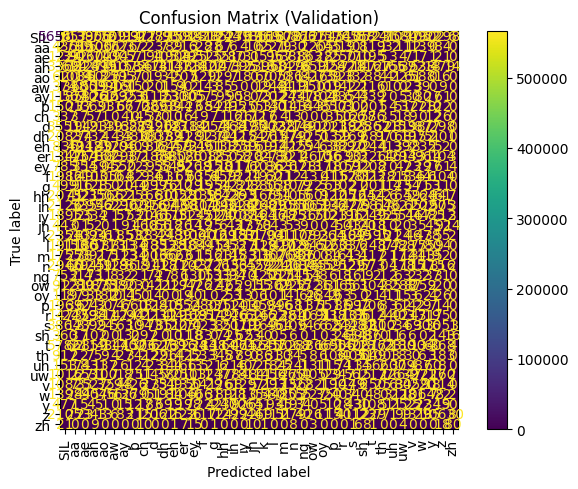

In [6]:

# === Evaluation (Confusion Matrix) ===
N = int(0.1 * len(X_all))
X_val = X_all[-N:]
y_val = y_all[-N:]
y_pred = model.predict(X_val).argmax(-1)

y_true_flat = y_val.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(len(distinct_phonemes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=90)
plt.tight_layout()
plt.title("Confusion Matrix (Validation)")
plt.show()

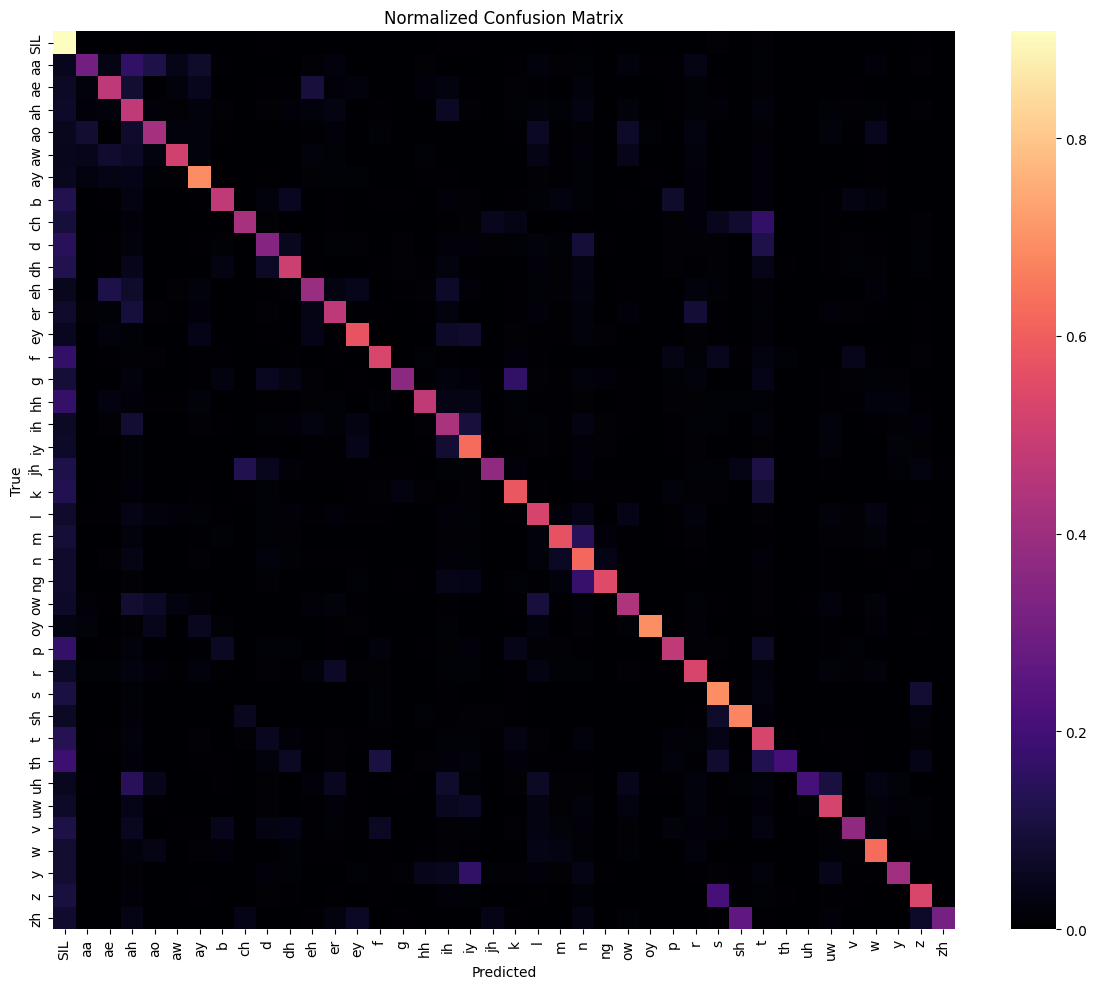

In [8]:
import seaborn as sns

cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cmap="magma", annot=False)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

conf_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
errors_only = conf_df.copy()
np.fill_diagonal(errors_only.values, 0)

top_confusions = errors_only.stack().sort_values(ascending=False).head(20)
print("Top 20 Confusions:\n", top_confusions)

Top 20 Confusions:
 t    SIL    5786
SIL  t      5723
     s      5105
z    s      4112
SIL  ah     3956
s    SIL    3864
SIL  n      3781
d    SIL    3551
ih   iy     3482
ah   SIL    3368
s    z      3053
ih   ah     2956
n    SIL    2946
d    t      2867
SIL  iy     2767
ah   ih     2732
m    n      2648
iy   ih     2408
k    SIL    2354
t    d      2327
dtype: int64


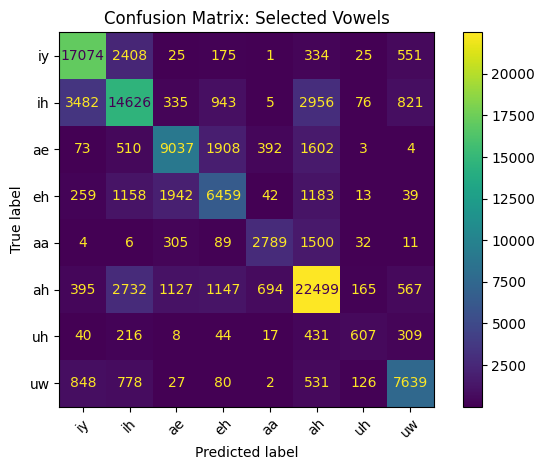

In [10]:
selected = ["iy", "ih", "ae", "eh", "aa", "ah", "uh", "uw"]
sel_idx = [np.where(label_encoder.classes_ == p)[0][0] for p in selected]
cm_sub = cm[np.ix_(sel_idx, sel_idx)]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_sub, display_labels=selected)
disp.plot(xticks_rotation=45, cmap="viridis")
plt.title("Confusion Matrix: Selected Vowels")
plt.tight_layout()
plt.show()